###Mount Drive and Import Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, mutual_info_regression, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Input data files are available in the "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/data_description.txt
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/train.csv
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/sample_submission.csv
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/test.csv


###Import and Clean Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/train.csv')
# Cleanup data
MSSubClassMap = {
    20: "1S_1946+",
    30: "1S_1945-",
    40: "1S_WA",
    45: "1.5S_U",
    50: "1.5S_F",
    60: "2S_1946+",
    70: "2S_1945-",
    75: "2.5S",
    80: "Split_Multi",
    85: "Split_Foyer",
    90: "Duplex",
    120: "1S_PUD_1946+",
    150: "1.5S_PUD",
    160: "2S_PUD_1946+",
    180: "PUD_Multi",
    190: "2_Fam_Conv"
}
df["MSSubClass"] = df["MSSubClass"].map(MSSubClassMap)
df['PoolQC'].fillna(value = 'None',inplace = True)
df['MiscFeature'].fillna(value = 'None',inplace = True)
df['Alley'].fillna(value = 'None',inplace = True)
df['Fence'].fillna(value = 'None',inplace = True)
df['FireplaceQu'].fillna(value = 'None',inplace = True)
df['GarageQual'].fillna(value = 'None',inplace = True)
df['BsmtQual'].fillna(value = 'None',inplace = True)
df['LotFrontage'].fillna(value = 0,inplace = True)
df = df[df['Electrical'].notna()]
df = df[df['MasVnrType'].notna()]

index1 = df[(df['BsmtExposure'].isna()) & (df['BsmtCond'].notna())].index
index2 = df[(df['BsmtFinType2'].isna()) & (df['BsmtCond'].notna())].index
df.drop(index = index1,axis=0,inplace=True)
df.drop(index = index2,axis=0,inplace=True)
df.drop(['GarageYrBlt'], axis=1, inplace=True)

#Seperate sales price column
df_SalePrice = df['SalePrice']
#drop id and sales price column from main dataframe
df.drop(["Id"], 1, inplace=True)
df.drop(['SalePrice'], axis=1, inplace=True)

# Merge dummies
def dummy_and_merge(new_col, old_cols):
  dummies = None
  for old_col in old_cols:
    if dummies is None:
      dummies = pd.get_dummies(df[old_col], prefix=new_col)
    else:                      
      dummies = dummies.add(pd.get_dummies(df[old_col], prefix=new_col), fill_value=0).astype(int).clip(0, 1)
  return dummies

condition_dummies = dummy_and_merge('Condition', ['Condition1', 'Condition2'])
df.drop(labels=['Condition1', 'Condition2'], axis=1, inplace=True)
exterior_dummies = dummy_and_merge('Exterior', ['Exterior1st', 'Exterior2nd'])
df.drop(labels=['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)
# Make dummy values
df_dummies = pd.get_dummies(df)
df_dummies = df_dummies.join(condition_dummies)
df_dummies = df_dummies.join(exterior_dummies)
# Display
pd.set_option('display.max_columns', None)
df_dummies.describe()
print(len(df_dummies.columns))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


288


In [4]:
numeric_features = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold"
    ]

###Configure Models

Scoring functions

In [5]:
def root_mean_squared_log_error(y_true, y_pred):
  try:
    return mean_squared_error(np.log(np.abs(y_true)), np.log(np.abs(y_pred)), squared=False)
  except:
    return 0

def rms_log_loss(estimator, X, y):
  return -root_mean_squared_log_error(estimator.predict(X), y)

Models

In [6]:
def build_pipeline(scaler, estimator):
  numeric_transformer = Pipeline(steps=[
      ('scaler', scaler)
  ])

  preprocessor = ColumnTransformer(
      transformers=[('numeric', numeric_transformer, numeric_features)],
      remainder = "passthrough"
  )

  pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', estimator)
  ])

  return pipeline

In [7]:
# Numerical Scalers
scalers = [
    StandardScaler(),
    #MinMaxScaler(),
    #RobustScaler(),
]

# Models
estimators = [
    LinearRegression(),
    LassoCV(max_iter=10000),
    ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, .91, .95, .97, .99, .995, .999], max_iter=10000),
    RidgeCV(scoring=None, store_cv_values=True, alphas=np.concatenate(([0.1], np.linspace(1, 100, num=99, endpoint=False)))),
    #MLPRegressor((64, 5), max_iter=1000, activation='relu', learning_rate_init=0.05, early_stopping=True),
]

###Train Models

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_SalePrice, test_size=0.20, random_state=None)

models = []

for scaler in scalers:
  print(f'{scaler}:\n')
  for estimator in estimators:
    pipeline = build_pipeline(scaler, estimator)
    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict(X_test)
    models.append(pipeline)
    print(str(estimator).split('(')[0])
    print(f'Model rms-log loss:{root_mean_squared_log_error(y_test, y_pred_test)}')
    print(f'Model r2 score:{pipeline.score(X_test, y_test)}\n')

StandardScaler():

LinearRegression
Model rms-log loss:3.1349100854105236
Model r2 score:-3.560528676193277e+18

LassoCV
Model rms-log loss:0.1478303789866026
Model r2 score:0.7848467175710937

ElasticNetCV
Model rms-log loss:0.14693145682911965
Model r2 score:0.8112441750101802

RidgeCV
Model rms-log loss:0.1758915086491916
Model r2 score:0.7414461492936231



In [9]:
for i in range(1, len(estimators)):
  selected_features = SelectFromModel(estimator=estimators[i], prefit=True)
  print(str(estimators[i]).split('(')[0])
  print(f'{len(selected_features.get_support(True))} features left')

LassoCV
142 features left
ElasticNetCV
93 features left
RidgeCV
66 features left


###Model Performance

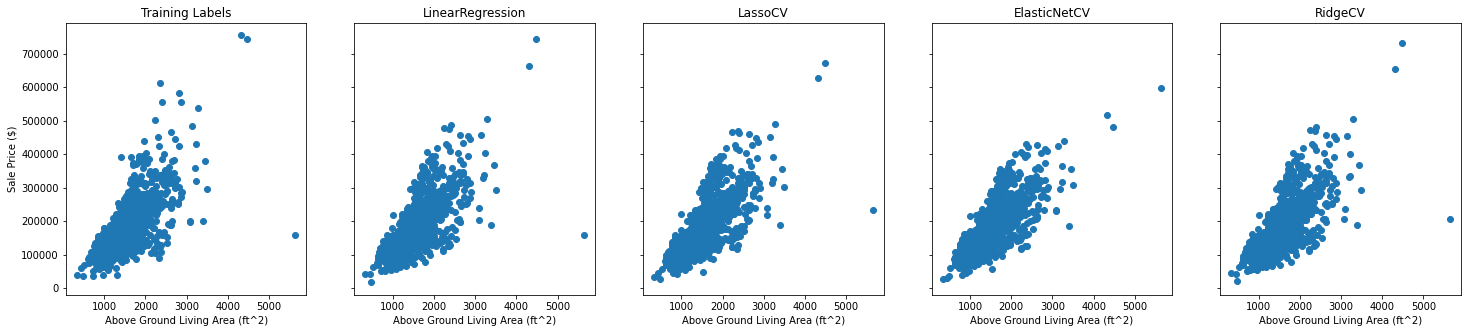

In [10]:
idx = "GrLivArea"
#idx = df_dummies.columns.get_loc(idx)

f, axes = plt.subplots(1, (len(estimators)+1), sharey=True, sharex=True, figsize=(5*(len(estimators)+1),5))

axes[0].set_ylabel('Sale Price ($)')
axes[0].scatter(X_train[idx], y_train)
axes[0].set_xlabel('Above Ground Living Area (ft^2)')
axes[0].set_title("Training Labels")

for i in range(len(models)):
  model = models[i]
  ax = axes[i+1]
  y_pred_train = model.predict(X_train)
  ax.scatter(X_train[idx], y_pred_train)
  ax.set_xlabel('Above Ground Living Area (ft^2)')
  ax.set_title(str(estimators[i]).split('(')[0])

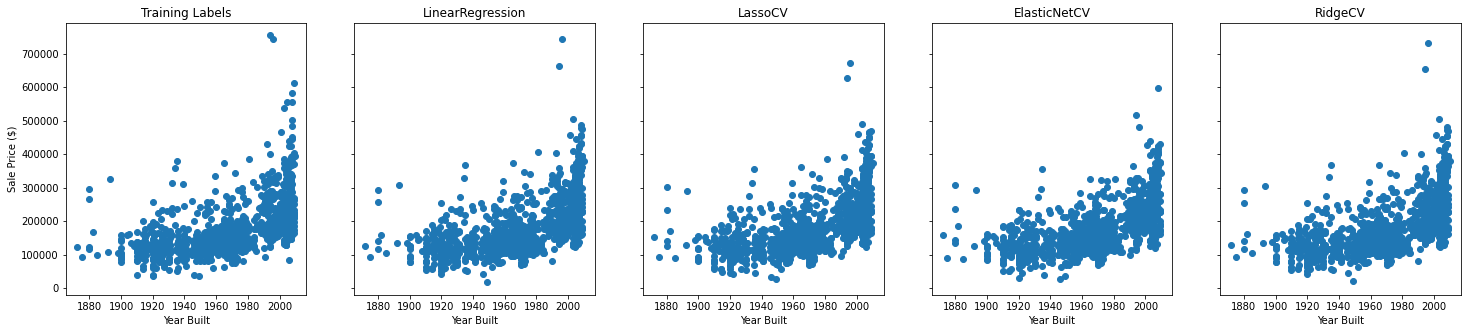

In [11]:
idx = "YearBuilt"
#idx = df_dummies.columns.get_loc(idx)

f, axes = plt.subplots(1, (len(estimators)+1), sharey=True, sharex=True, figsize=(5*(len(estimators)+1),5))

axes[0].set_ylabel('Sale Price ($)')
axes[0].scatter(X_train[idx], y_train)
axes[0].set_xlabel('Year Built')
axes[0].set_title("Training Labels")

for i in range(len(models)):
  model = models[i]
  ax = axes[i+1]
  y_pred_train = model.predict(X_train)
  ax.scatter(X_train[idx], y_pred_train)
  ax.set_xlabel('Year Built')
  ax.set_title(str(estimators[i]).split('(')[0])

(1159, 100)


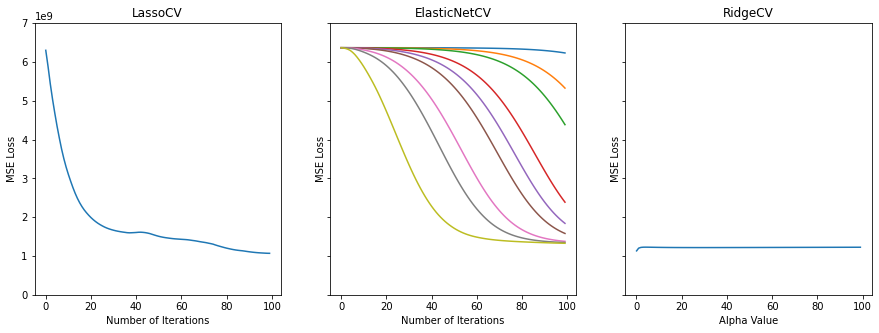

In [12]:
f, axes = plt.subplots(1, (len(estimators)-1), sharey=True, figsize=(5*(len(estimators)-1),5))
plt.ylim(top=1.1*np.max(np.concatenate([np.mean(estimators[1].mse_path_[:, :], axis=1),
                                        np.max(np.mean(estimators[2].mse_path_[:, :, :], axis=2).T, axis=0)])))
                                        #np.mean(estimators[2].cv_values_[:,:], axis=0)])))

for i in range(0, len(estimators)-1):
  estimator = estimators[i+1]
  ax = axes[i]
  ax.set_xlabel('Number of Iterations')
  ax.set_title(str(estimator).split('(')[0])
axes[0].set_ylabel('MSE Loss')
axes[0].plot(np.mean(estimators[1].mse_path_[:, :], axis=1))

axes[1].set_ylabel('MSE Loss')
axes[1].plot(np.mean(estimators[2].mse_path_[:, :, :], axis=2).T)

axes[2].set_xlabel('Alpha Value')
axes[2].set_ylabel('MSE Loss')
axes[2].plot(np.concatenate(([0.1], np.linspace(1, 100, num=99, endpoint=False))), np.mean(estimators[3].cv_values_[:,:], axis=0))
print(np.shape(estimators[3].cv_values_))

#axes[3].set_ylabel('MSE Loss')
#axes[3].plot(np.arange(1, np.size(estimators[3].loss_curve_)+1, step=1), estimators[3].loss_curve_)


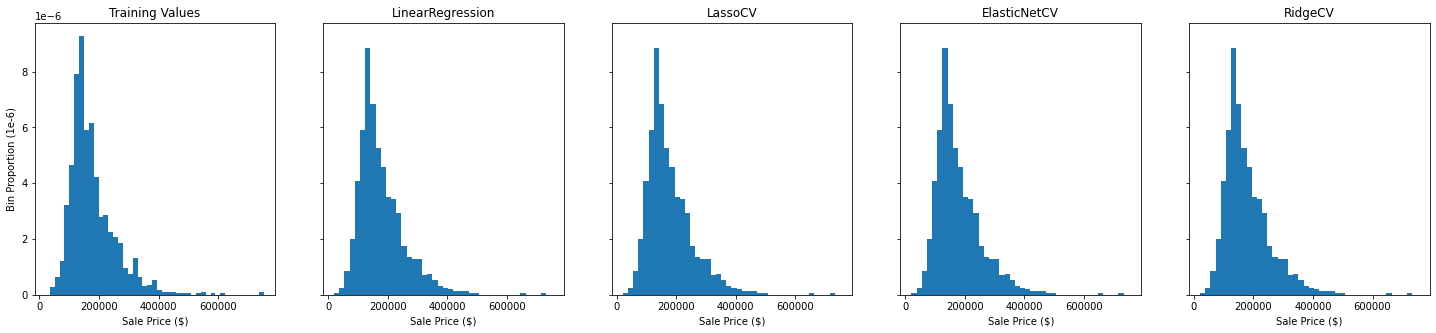

In [13]:
def plot_hist(X, ax):
  IQR = np.quantile(X, 0.75) - np.quantile(X, 0.25)
  bin_width = 2 * IQR * pow(X.count(), -1/3)  # Use Freedman and Diaconis’ rule to find bin width
  bins = int((X.max() - X.min())/bin_width)
  X.plot.hist(bins=bins, density=1, ax=ax) 

f, axes = plt.subplots(1, (len(estimators)+1), sharey=True, sharex=True, figsize=(5*(len(estimators)+1),5))

plot_hist(y_train, axes[0])
axes[0].set_ylabel('Bin Proportion (1e-6)')
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_title('Training Values')

for i in range(len(models)):
  model = models[i]
  ax = axes[i+1]
  y_pred_train = pipeline.predict(X_train)
  plot_hist(pd.Series(y_pred_train), ax)
  ax.set_xlabel('Sale Price ($)')
  ax.set_title(str(estimators[i]).split('(')[0])

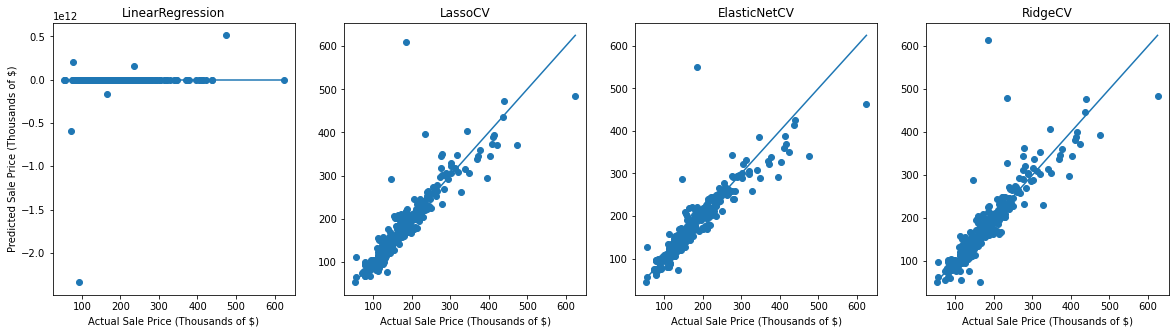

In [14]:
f, axes = plt.subplots(1, (len(estimators)), sharex=True, figsize=(5*(len(estimators)),5))

axes[0].set_ylabel('Predicted Sale Price (Thousands of $)')

for i in range(len(models)):
  model = models[i]
  ax = axes[i]
  y_pred_test = model.predict(X_test)
  ax.scatter(y_test/1000, y_pred_test/1000)
  ax.plot([np.min(y_test)/1000,np.max(y_test)/1000], [np.min(y_test)/1000,np.max(y_test)/1000])
  ax.set_xlabel('Actual Sale Price (Thousands of $)')
  ax.set_title(str(estimators[i]).split('(')[0])